# Segmentación de Clientes para DesignReels

En el competitivo mundo del comercio electrónico, entender a fondo a nuestros clientes es fundamental para ofrecer experiencias personalizadas y maximizar la satisfacción y lealtad del cliente. Este análisis de segmentación de clientes tiene como objetivo explorar y comprender las distintas características y comportamientos de los clientes que interactúan con nuestra tienda en línea, especializada en productos creativos.

Utilizando técnicas avanzadas de análisis de datos, como clustering y segmentación, este estudio buscará identificar grupos homogéneos de clientes. Estos segmentos nos permitirán personalizar estrategias de marketing más efectivas, optimizar la selección de productos y mejorar la experiencia general de compra. Al comprender las necesidades y preferencias únicas de cada segmento, aspiramos a fortalecer la conexión emocional con la marca y aumentar la retención de clientes a largo plazo.

A lo largo de este análisis, exploraremos cómo diferentes segmentos de clientes interactúan con nuestros productos, qué atributos compartidos tienen y cómo podemos adaptar nuestras iniciativas de negocio para satisfacer mejor sus expectativas. Este enfoque estratégico no solo impulsará el crecimiento y la rentabilidad de DesignReels, sino que también nos permitirá destacar en un mercado saturado al ofrecer soluciones que verdaderamente resuenen con nuestros clientes.

Juntos, avanzaremos hacia una comprensión más profunda de nuestros clientes y hacia la creación de experiencias de compra personalizadas y significativas que fortalezcan la posición de DesignReels como líder en su categoría de productos creativos.


# Diccionario de datos 

El conjunto de datos contiene información detallada sobre las transacciones de ventas de la tienda 

Descripción de las Columnas

- invoice_no: Número de factura generado para cada transacción.
- stock_code: Código único que identifica cada producto vendido.
- description: Descripción del producto vendido.
- quantity: Cantidad de unidades vendidas de cada producto en la factura.
- invoice_date: Fecha y hora en que se emitió la factura.
- unit_price: Precio unitario del producto en la factura.
- customer_id: Identificación única del cliente que realizó la compra.
- region: Región o ubicación del cliente.
- total: Total de la venta, calculado como la cantidad vendida multiplicada por el precio unitario.

In [1593]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

In [1594]:
df = pd.read_csv(r'datasets\Online_Retail.csv', encoding='iso-8859-1')

In [1595]:
df.sample(10)

,INVOICE_NO,STOCK_CODE,DESCRIPTION,QUANTITY,INVOICE_DATE,UNIT_PRICE,CUSTOMER_ID,REGION
315595,564733,82001S,VINYL RECORD FRAME SILVER,1,28/08/2020 13:18,3.75,17841.0,United Kingdom
40252,539733,22720,SET OF 3 CAKE TINS PANTRY DESIGN,1,21/12/2019 15:13,4.95,NaN,United Kingdom
475431,576889,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,2,16/11/2020 17:24,2.55,12748.0,United Kingdom
501895,578833,22174,PHOTO CUBE,1,25/11/2020 15:23,4.13,NaN,United Kingdom
98485,544681,84755,COLOUR GLASS T-LIGHT HOLDER HANGING,8,22/02/2020 16:28,1.24,NaN,United Kingdom
341445,566757,84378,SET OF 3 HEART COOKIE CUTTERS,1,14/09/2020 15:54,2.46,NaN,United Kingdom
160962,550470,21246,RED RETROSPOT BIG BOWL,1,18/04/2020 13:49,4.13,NaN,United Kingdom
401834,571442,22846,BREAD BIN DINER STYLE RED,1,17/10/2020 13:39,16.95,17049.0,United Kingdom
440391,574532,22768,FAMILY PHOTO FRAME CORNICE,2,04/11/2020 14:19,9.95,15676.0,United Kingdom
497489,578374,21937,found,50,24/11/2020 11:21,0.00,NaN,United Kingdom


In [1596]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   INVOICE_NO    541909 non-null  object 
 1   STOCK_CODE    541909 non-null  object 
 2   DESCRIPTION   540455 non-null  object 
 3   QUANTITY      541909 non-null  int64  
 4   INVOICE_DATE  541909 non-null  object 
 5   UNIT_PRICE    541909 non-null  float64
 6   CUSTOMER_ID   406829 non-null  float64
 7   REGION        541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [1597]:
#cambio del nombre de las columnas a minusculas
new_col_name = []

for old_name in df.columns:
    name_stripped = old_name.strip()
    # Luego, pon todas las letras en minúsculas
    name_lowered = name_stripped.lower()
    # Por último, reemplaza los espacios entre palabras por guiones bajos
    name_no_spaces = name_lowered.replace(' ', '_')
    # Agrega el nuevo nombre a la lista de nuevos nombres de columna
    new_col_name.append(name_no_spaces)

df.columns = new_col_name


In [1598]:
#cambio de tipo de la columna invoce_date a datetime
df['invoice_date']=pd.to_datetime(df['invoice_date'], format="%d/%m/%Y %H:%M")

In [1599]:
#se llenan los nan de la columna customer_id con 0
df['customer_id'] = df['customer_id'].fillna(0)

In [1600]:
#cambio del tipo de la columna customer_id a entero
df['customer_id'] = df['customer_id'].astype(int)

In [1601]:
df.sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
388756,570455,23265,SET OF 3 WOODEN TREE DECORATIONS,1,2020-10-10 15:27:00,1.25,14529,United Kingdom
324998,565427,20764,ABSTRACT CIRCLES SKETCHBOOK,1,2020-09-04 12:49:00,3.75,17774,United Kingdom
465548,C576244,D,Discount,-1,2020-11-14 13:40:00,6.00,18167,United Kingdom
161287,550473,21466,RED FLOWER CROCHET FOOD COVER,2,2020-04-18 13:54:00,3.75,14623,United Kingdom
419137,572758,22981,PANTRY APPLE CORER,1,2020-10-25 18:39:00,2.92,0,United Kingdom
301282,563252,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2020-08-15 11:59:00,7.95,17655,United Kingdom
464583,576137,23084,RABBIT NIGHT LIGHT,24,2020-11-14 10:45:00,1.79,15482,United Kingdom
486578,577740,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,3,2020-11-21 13:36:00,2.55,17625,United Kingdom
358347,568142,23345,DOLLY GIRL BEAKER,2,2020-09-25 11:22:00,1.25,16744,United Kingdom
459670,575875,35648,VINTAGE BEAD PINK PURSE,2,2020-11-11 13:06:00,1.63,0,United Kingdom


In [1602]:
df['region'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [1603]:
#se remplaza el nombre de los paises agregaqdos como EIRE y RSA para unificar todos los nombres en ingles y mayusculas y minusculas 
df['region']= df['region'].replace('EIRE', 'Ireland')

In [1604]:
df['region']= df['region'].replace('RSA', 'Sudafrica')

In [1605]:
df['region'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'Ireland', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'Sudafrica'], dtype=object)

In [1606]:
#verificacion de los valores menores a cero en la columan quantity. Se toma la decision de eliminarlo al no considerar que aporten informacion relevante 
df[df['quantity'] < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
141,C536379,D,Discount,-1,2019-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2019-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2019-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2019-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2019-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2020-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2020-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2020-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2020-12-09 11:58:00,1.25,17315,United Kingdom


In [1607]:
#verificacion de los valores menores a cero en la columan unit_price. Se toma la decision de eliminarlo al no considerar que aporten informacion relevante  
df[df['unit_price'] < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
299983,A563186,B,Adjust bad debt,1,2020-08-12 14:51:00,-11062.06,0,United Kingdom
299984,A563187,B,Adjust bad debt,1,2020-08-12 14:52:00,-11062.06,0,United Kingdom


In [1608]:
#creacion de una nueva columana que calcula el total vendido por factura 
df['total'] = df['quantity'] * df['unit_price']

In [1609]:
#se convierten las descripciones a minuscula para unificar el formato 
df['description'] = df['description'].str.lower()

In [1610]:
df.sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
312443,564353,23153,zinc sweetheart wire letter rack,4,2020-08-24 15:08:00,3.75,15764,United Kingdom,15.00
284488,561874,22985,wrap billboard fonts design,25,2020-07-31 12:02:00,0.42,16255,United Kingdom,10.50
10389,537237,21929,jumbo bag pink vintage paisley,2,2019-12-06 09:58:00,4.21,0,United Kingdom,8.42
438670,574328,85014A,black/blue polkadot umbrella,3,2020-11-04 09:05:00,5.95,13081,United Kingdom,17.85
4235,536754,22274,feltcraft doll emily,3,2019-12-02 14:09:00,2.95,14449,United Kingdom,8.85
425808,573339,22959,wrap christmas village,25,2020-10-30 11:49:00,0.42,13278,United Kingdom,10.50
128309,547253,22692,doormat welcome to our home,2,2020-03-22 10:44:00,7.95,13869,United Kingdom,15.90
158493,550297,20914,set/5 red retrospot lid glass bowls,5,2020-04-15 15:58:00,2.95,14056,United Kingdom,14.75
367968,568917,23319,box of 6 mini 50's crackers,6,2020-09-29 14:11:00,2.49,15955,United Kingdom,14.94
420964,572913,85123A,white hanging heart t-light holder,4,2020-10-26 16:21:00,2.95,15993,United Kingdom,11.80


In [1611]:
#verificar que no existe ningun valor 0 en la columna quantity; sin embargo tener en cuenta que si existen aun menores a 0 
df[df['quantity'] == 0]


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total


In [1612]:
#se decide eliminar del dataframe los datos que en unit_price y en customer_id sean iguales a 0, dado que consideramos no aportan ningun informacion util para futuros analisis
ceros = df.query('unit_price > 0 & customer_id > 0')
display(ceros)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
0,536365,85123A,white hanging heart t-light holder,6,2019-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2019-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,pack of 20 spaceboy napkins,12,2020-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,children's apron dolly girl,6,2020-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,childrens cutlery dolly girl,4,2020-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,childrens cutlery circus parade,4,2020-12-09 12:50:00,4.15,12680,France,16.60


In [1613]:
#verificacion relacionado con los datos eliminados 
ceros['description'].unique()

array(['white hanging heart t-light holder', 'white metal lantern',
       'cream cupid hearts coat hanger', ...,
       'pink crystal skull phone charm',
       'cream hanging heart t-light holder', 'paper craft  little birdie'],
      dtype=object)

In [1614]:
#verificacion relacionado con los datos eliminados 
ceros['region'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'Ireland', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'Sudafrica'], dtype=object)

In [1615]:
#verificacion relacionado con los datos eliminados 
ceros['invoice_date'].dt.year.unique()


array([2019, 2020])

In [1616]:
#verificacion relacionado con los datos eliminados 
ceros['invoice_date'].dt.month.unique()

array([12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [1617]:
#se filta el data frame despues de las verificaciones anteriores para conservar unicamente los datos que sean diferentes a 0 

df = df.query('unit_price > 0.0 & customer_id > 0 & quantity > 0')

In [1618]:
#Se observan los valores maximos de la columna unit price y nos damos cuenta que hay facturas que no son productos como tal, cuyos monton son muy altos dado que el valor por unidad es elevado tambien
#al parecer estas facturas corresponden a gastos de envio y/0 gastos varios que podrian afectar nuestra analisis de clientes, dado que nos interesa unicamente sus compras se eliminan del dataset
df[df['unit_price']>= 450]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
117054,546328,M,manual,1,2020-03-11 10:19:00,1687.17,14911,Ireland,1687.17
117055,546329,M,manual,1,2020-03-11 10:22:00,1687.17,14911,Ireland,1687.17
144826,548813,M,manual,1,2020-04-04 13:03:00,2382.92,12744,Singapore,2382.92
144828,548813,M,manual,1,2020-04-04 13:03:00,1252.95,12744,Singapore,1252.95
144829,548820,M,manual,1,2020-04-04 13:04:00,2053.07,12744,Singapore,2053.07
145831,548913,M,manual,1,2020-04-05 09:45:00,1136.30,12669,France,1136.30
150615,549468,M,manual,1,2020-04-08 14:27:00,1867.86,17940,United Kingdom,1867.86
173382,551697,POST,postage,1,2020-05-03 13:46:00,8142.75,16029,United Kingdom,8142.75
187584,552980,POST,postage,1,2020-05-12 14:52:00,523.00,12590,Germany,523.00
188277,553018,M,manual,1,2020-05-12 19:02:00,557.72,12757,Portugal,557.72


In [1619]:
#Se eliminando estos valores dado que no parecen ser ventas realizadas como tal por la empresa. 
df = df[~df['stock_code'].isin(['M', 'DOT', 'POST'])]

In [1620]:
df[df['unit_price']>= 450]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
222680,556444,22502,picnic basket wicker 60 pieces,60,2020-06-10 15:28:00,649.5,15098,United Kingdom,38970.0
222682,556446,22502,picnic basket wicker 60 pieces,1,2020-06-10 15:33:00,649.5,15098,United Kingdom,649.5


In [1621]:
df[df['unit_price'] == 0.0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total


In [1622]:
df[df['quantity'] == 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total


In [1623]:
df.sample(20)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
262219,559904,82482,wooden picture frame white finish,6,2020-07-13 13:20:00,2.55,13149,United Kingdom,15.30
506601,579146,22910,paper chain kit vintage christmas,5,2020-11-28 13:14:00,2.95,16347,United Kingdom,14.75
142484,548612,21458,2 picture book eggs easter bunny,3,2020-04-01 11:34:00,1.25,13137,United Kingdom,3.75
156400,550137,22212,four hook white lovebirds,12,2020-04-14 13:59:00,2.10,12477,Germany,25.20
510052,579414,22112,chocolate hot water bottle,1,2020-11-29 12:52:00,4.95,14719,United Kingdom,4.95
508229,579196,22654,deluxe sewing kit,2,2020-11-28 15:54:00,11.63,14096,United Kingdom,23.26
134015,547816,21925,union stripe cushion cover,1,2020-03-25 14:30:00,1.25,12748,United Kingdom,1.25
478902,577109,22535,magic drawing slate bunnies,24,2020-11-17 17:50:00,0.42,16042,United Kingdom,10.08
522864,580469,22594,christmas gingham tree,1,2020-12-04 12:32:00,0.85,14583,United Kingdom,0.85
538687,581412,23147,single antique rose hook ivory,6,2020-12-08 14:38:00,1.45,14415,United Kingdom,8.70


In [1624]:
df[df['customer_id']==17850]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
0,536365,85123A,white hanging heart t-light holder,6,2019-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2019-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
4540,536790,22752,set 7 babushka nesting boxes,4,2019-12-02 15:26:00,7.65,17850,United Kingdom,30.60
4541,536790,22803,ivory embroidered quilt,3,2019-12-02 15:26:00,35.75,17850,United Kingdom,107.25
4542,536790,21730,glass star frosted t-light holder,12,2019-12-02 15:26:00,4.25,17850,United Kingdom,51.00
4543,536791,22632,hand warmer red polka dot,12,2019-12-02 15:27:00,1.85,17850,United Kingdom,22.20


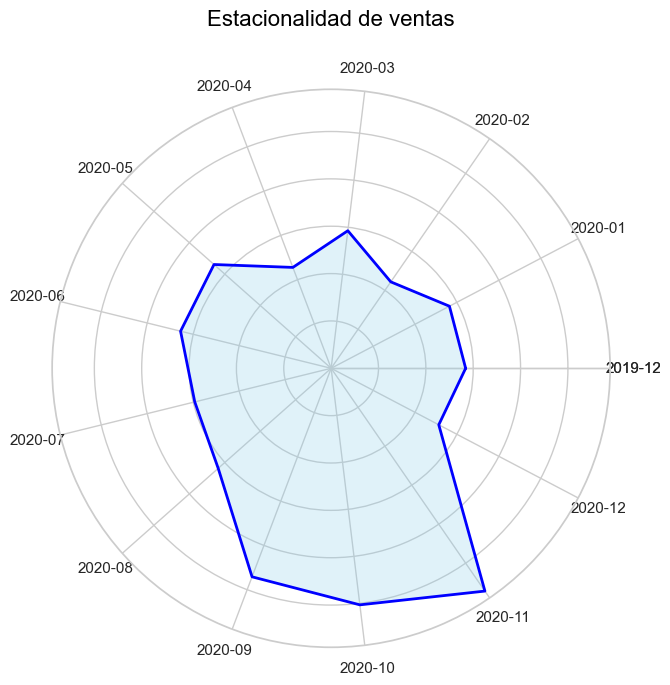

In [1625]:
#Estacionalidad de ventas GRAFICO DE RADAR/SPIDER
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

df['month_year'] = df['invoice_date'].dt.to_period('M')

ventas_mensuales = df.groupby('month_year')['total'].sum().reset_index()

ventas_mensuales['month_year'] = ventas_mensuales['month_year'].dt.to_timestamp()

labels = ventas_mensuales['month_year'].dt.strftime('%Y-%m').tolist()
stats = ventas_mensuales['total'].values

num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

stats = np.concatenate((stats, [stats[0]]))
angles += angles[:1]
labels += [labels[0]]

fig, ax = plt.subplots(figsize=(14, 7), subplot_kw=dict(polar=True))

ax.fill(angles, stats, color='skyblue', alpha=0.25)
ax.plot(angles, stats, color='blue', linewidth=2)

ax.set_xticks(angles)
ax.set_xticklabels(labels)

plt.title('Estacionalidad de ventas', size=16, color='black', y=1.1)
ax.set_yticklabels([])

plt.tight_layout()
plt.show()

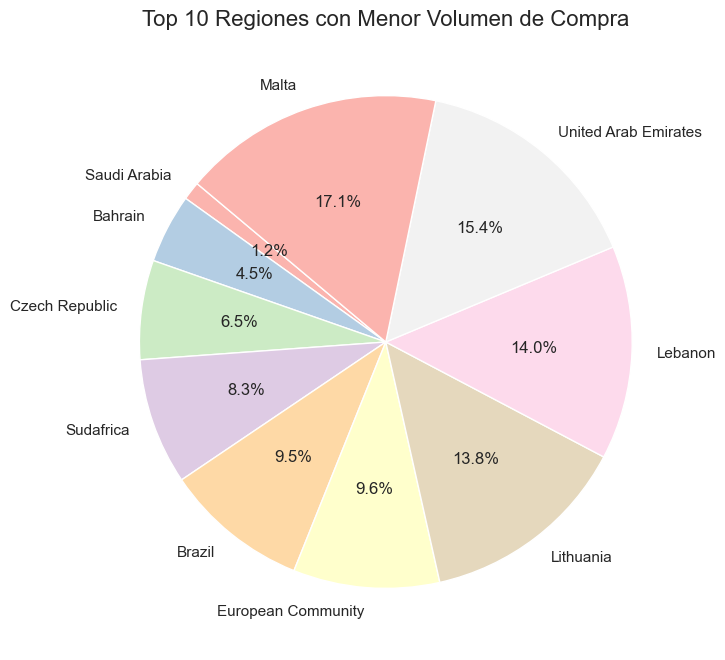

In [1626]:
#Bottom 10 regiones con el menor volumen de ventas
ventas_por_region = df.groupby('region')['total'].sum().sort_values()

#Seleccionar las 10 regiones con el menor volumen de compras
bottom_10_regiones = ventas_por_region.head(10)

#Crear el gráfico de torta
plt.figure(figsize=(10, 8))
plt.pie(bottom_10_regiones, labels=bottom_10_regiones.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Top 10 Regiones con Menor Volumen de Compra', fontsize=16)
plt.show()

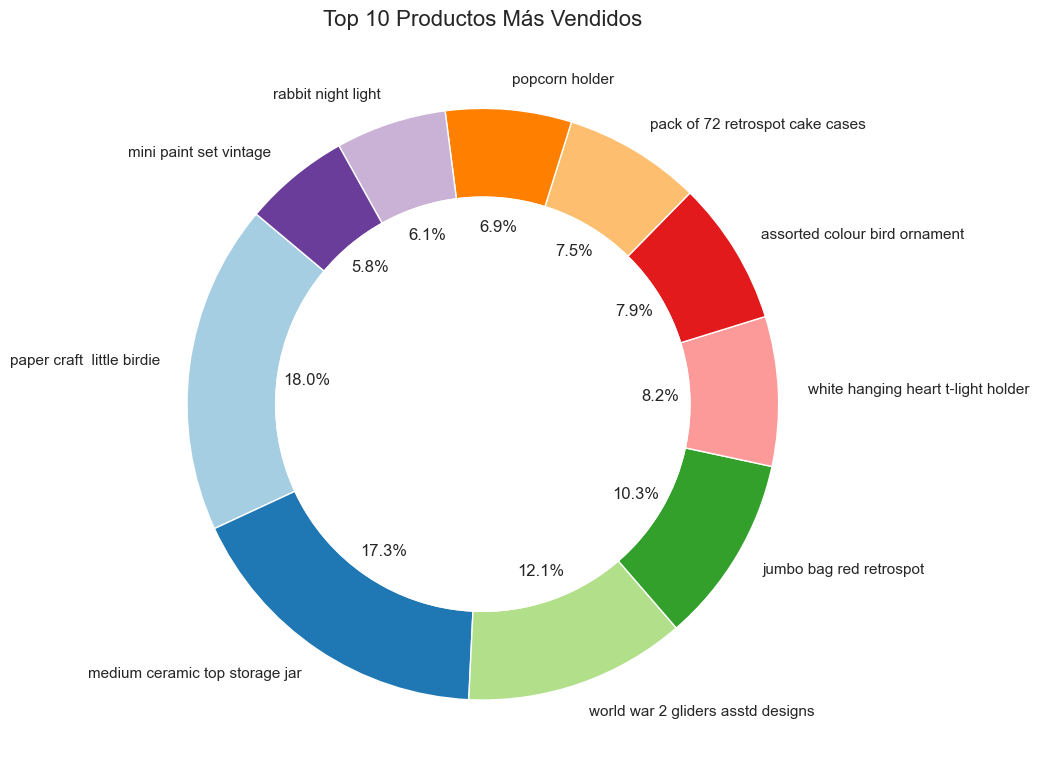

In [1627]:
#Productos más vendidos segun descripción GRAFICO DE DONA
productos_mas_vendidos = df.groupby('description')['quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
plt.pie(productos_mas_vendidos, labels=productos_mas_vendidos.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, wedgeprops=dict(width=0.3))


centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.title('Top 10 Productos Más Vendidos', fontsize=16)

plt.tight_layout()
plt.show()

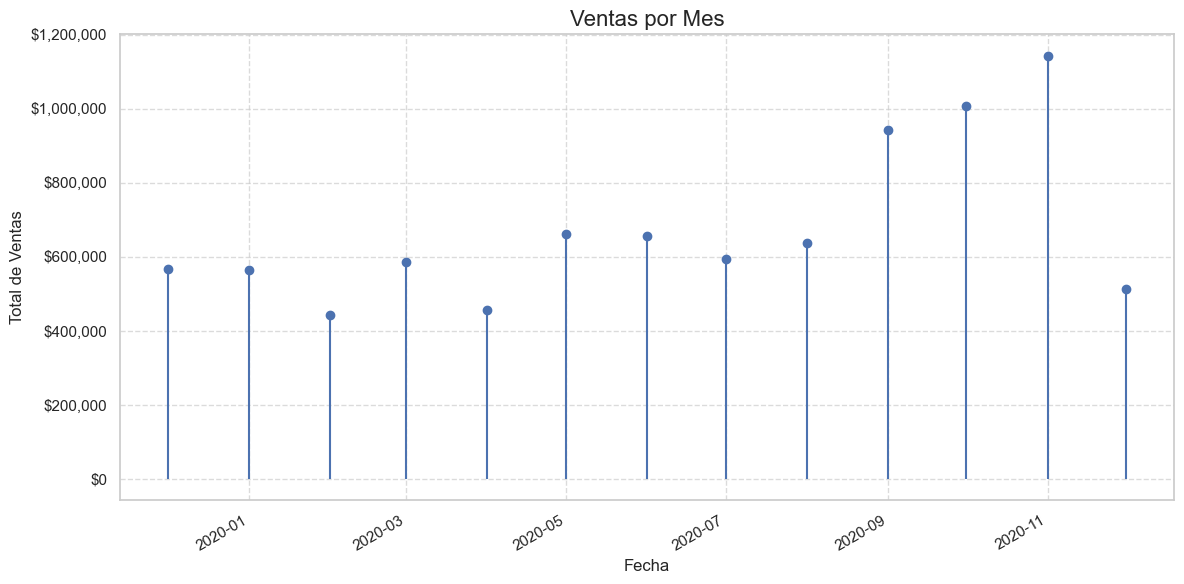

In [1628]:
# Convertir invoice_date a formato datetime si no lo está
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

# Agrupar por mes y sumar las ventas totales
ventas_mensuales = df.groupby(df['invoice_date'].dt.to_period('M'))['total'].sum().reset_index()

# Convertir la columna de fechas a formato timestamp
ventas_mensuales['invoice_date'] = ventas_mensuales['invoice_date'].dt.to_timestamp()

# Crear el gráfico de lollipop
plt.figure(figsize=(12, 6))
plt.stem(ventas_mensuales['invoice_date'], ventas_mensuales['total'], linefmt='b-', markerfmt='bo', basefmt=" ")

# Configuración del gráfico
plt.title('Ventas por Mes', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Total de Ventas', fontsize=12)
plt.gcf().autofmt_xdate()  # Formato automático de las fechas en el eje x
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))  # Formato de los números en el eje y
plt.grid(True, linestyle='--', alpha=0.7)  # Activar la cuadrícula con estilo punteado y transparencia
plt.tight_layout()  # Ajuste del diseño del gráfico
plt.show()  # Mostrar el gráfico

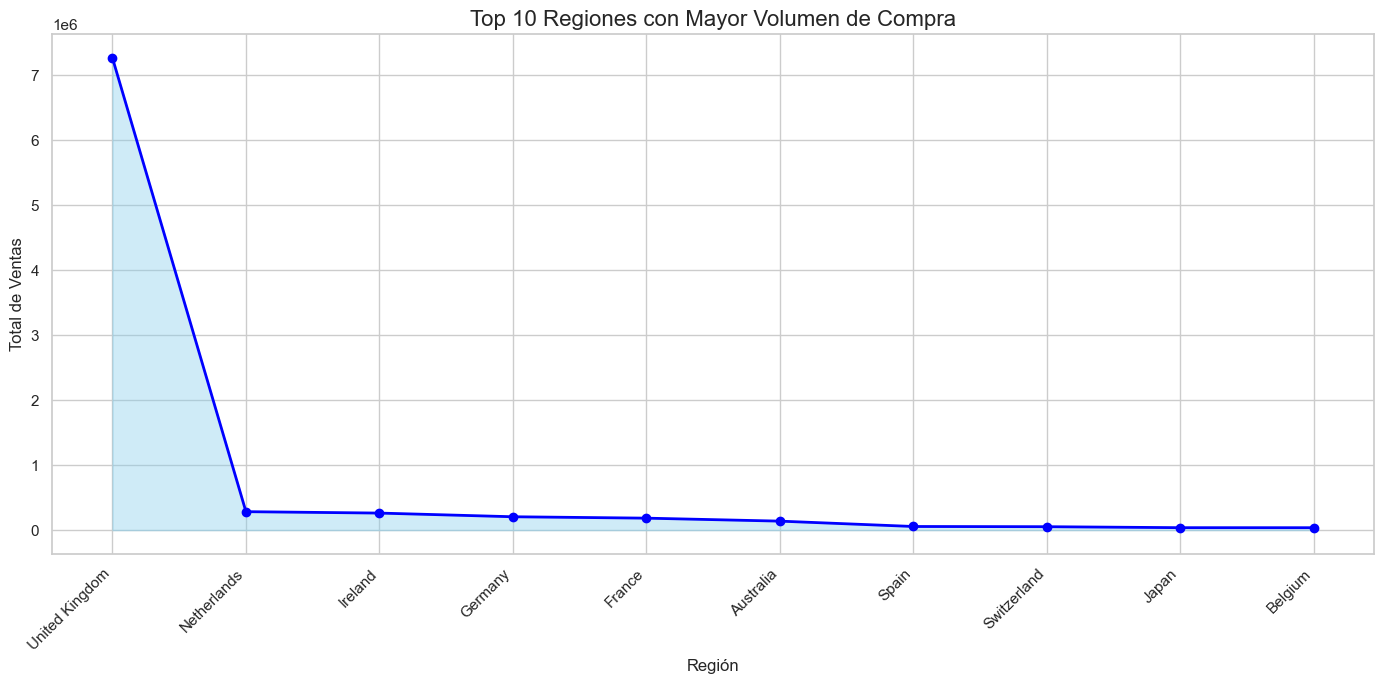

In [1629]:
#Top 10 regiones que más compran GRÁFICO DE AREA
ventas_por_region = df.groupby('region')['total'].sum().sort_values(ascending=False)

top_10_regiones = ventas_por_region.head(10)

plt.figure(figsize=(14, 7))
plt.fill_between(top_10_regiones.index, top_10_regiones.values, color='skyblue', alpha=0.4)
plt.plot(top_10_regiones.index, top_10_regiones.values, marker='o', color='blue', linewidth=2)

plt.title('Top 10 Regiones con Mayor Volumen de Compra', fontsize=16)
plt.xlabel('Región', fontsize=12)
plt.ylabel('Total de Ventas', fontsize=12)
plt.grid(True)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()
#Esta libreria usé para la grfica de lineas paralelas:
from pandas.plotting import parallel_coordinates

In [1630]:
# Calcular el número de compras por cliente
numero_compras = df.groupby('customer_id')['invoice_no'].count().reset_index()
numero_compras.columns = ['customer_id', 'numero_compras']

# Calcular los ingresos totales por cliente
ingresos_totales = df.groupby('customer_id')['total'].sum().reset_index()
ingresos_totales.columns = ['customer_id', 'ingresos_totales']

# Unir los datos calculados con el DataFrame original
df = pd.merge(df, numero_compras, on='customer_id', how='left')
df = pd.merge(df, ingresos_totales, on='customer_id', how='left')

# Calcular el número de clientes únicos
numero_clientes_unicos = df['customer_id'].nunique()

# Calcular los clientes retenidos (clientes con más de una compra)
clientes_retenidos = df[df['numero_compras'] > 1]['customer_id'].nunique()

In [1631]:
def categorizar_cliente(num_compras):
    if num_compras > 1:
        return 'retenido'
    else:
        return 'perdido'

In [1632]:
df['estado_cliente'] = df['numero_compras'].apply(categorizar_cliente)

In [1633]:
df

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total,month_year,numero_compras,ingresos_totales,estado_cliente
0,536365,85123A,white hanging heart t-light holder,6,2019-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2019-12,297,5391.21,retenido
1,536365,71053,white metal lantern,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2019-12,297,5391.21,retenido
2,536365,84406B,cream cupid hearts coat hanger,8,2019-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2019-12,297,5391.21,retenido
3,536365,84029G,knitted union flag hot water bottle,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2019-12,297,5391.21,retenido
4,536365,84029E,red woolly hottie white heart.,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2019-12,297,5391.21,retenido
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396480,581587,22613,pack of 20 spaceboy napkins,12,2020-12-09 12:50:00,0.85,12680,France,10.20,2020-12,49,790.81,retenido
396481,581587,22899,children's apron dolly girl,6,2020-12-09 12:50:00,2.10,12680,France,12.60,2020-12,49,790.81,retenido
396482,581587,23254,childrens cutlery dolly girl,4,2020-12-09 12:50:00,4.15,12680,France,16.60,2020-12,49,790.81,retenido
396483,581587,23255,childrens cutlery circus parade,4,2020-12-09 12:50:00,4.15,12680,France,16.60,2020-12,49,790.81,retenido


In [1634]:
df['AVP'] = df['ingresos_totales'] / df['numero_compras']



In [1635]:
df['APF'] = df['numero_compras'] / numero_clientes_unicos

CR = 1 - clientes_retenidos / numero_clientes_unicos


In [1636]:
df['CLTV'] = (df['AVP'] * df['APF']) / CR

In [1637]:
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total,month_year,numero_compras,ingresos_totales,estado_cliente,AVP,APF,CLTV
0,536365,85123A,white hanging heart t-light holder,6,2019-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2019-12,297,5391.21,retenido,18.152222,0.068512,73.852192
1,536365,71053,white metal lantern,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2019-12,297,5391.21,retenido,18.152222,0.068512,73.852192
2,536365,84406B,cream cupid hearts coat hanger,8,2019-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2019-12,297,5391.21,retenido,18.152222,0.068512,73.852192
3,536365,84029G,knitted union flag hot water bottle,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2019-12,297,5391.21,retenido,18.152222,0.068512,73.852192
4,536365,84029E,red woolly hottie white heart.,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2019-12,297,5391.21,retenido,18.152222,0.068512,73.852192


In [1638]:
#se verificaron los posibles datos duplicados en todas las columanas posibles y concluimos que los duplicados existentes son coherentes. No se elimina ninguno
df['stock_code'].duplicated().sum()

392823

In [1639]:
df.describe()

,quantity,invoice_date,unit_price,customer_id,total,numero_compras,ingresos_totales,AVP,APF,CLTV
count,396485.000000,396485,396485.000000,396485.000000,396485.000000,396485.000000,396485.000000,396485.000000,396485.000000,396485.000000
mean,13.008066,2020-07-10 20:02:19.138226944,2.884385,15301.436912,22.114122,662.026516,11244.428131,22.114122,0.152717,154.033262
min,1.000000,2019-12-01 08:26:00,0.001000,12346.000000,0.001000,1.000000,3.750000,2.101286,0.000231,0.051370
25%,2.000000,2020-04-07 11:16:00,1.250000,13975.000000,4.680000,90.000000,1092.390000,7.056183,0.020761,14.964247
50%,6.000000,2020-07-31 14:39:00,1.950000,15159.000000,11.800000,201.000000,2622.570000,15.080400,0.046367,35.925616
75%,12.000000,2020-10-20 14:40:00,3.750000,16801.000000,19.800000,444.000000,6068.110000,21.112403,0.102422,83.124795
max,80995.000000,2020-12-09 12:50:00,649.500000,18287.000000,168469.600000,7838.000000,279138.020000,77183.600000,1.808074,3823.808493
std,179.607863,NaN,4.354867,1709.758505,308.841950,1444.589307,30777.337890,206.091136,0.333239,421.607368


In [1640]:
#dataset limpio y con tipos de valor correcto
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396485 entries, 0 to 396484
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   invoice_no        396485 non-null  object        
 1   stock_code        396485 non-null  object        
 2   description       396485 non-null  object        
 3   quantity          396485 non-null  int64         
 4   invoice_date      396485 non-null  datetime64[ns]
 5   unit_price        396485 non-null  float64       
 6   customer_id       396485 non-null  int32         
 7   region            396485 non-null  object        
 8   total             396485 non-null  float64       
 9   month_year        396485 non-null  period[M]     
 10  numero_compras    396485 non-null  int64         
 11  ingresos_totales  396485 non-null  float64       
 12  estado_cliente    396485 non-null  object        
 13  AVP               396485 non-null  float64       
 14  APF 

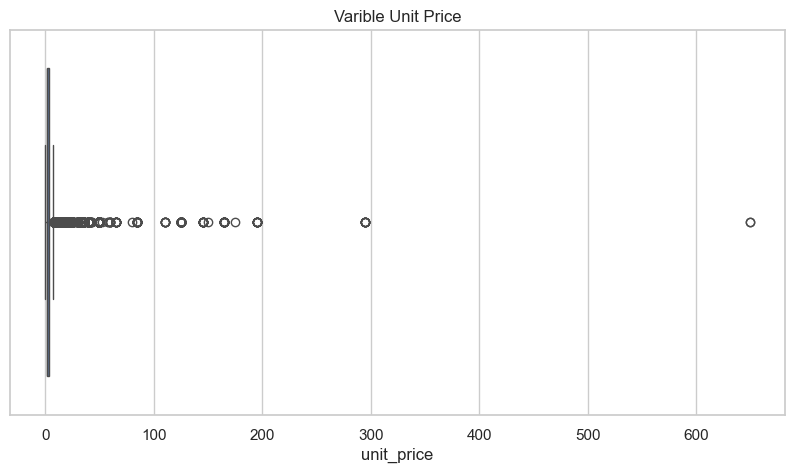

In [1641]:
# Graficar un boxplot para identificar valores atípicos
plt.figure(figsize=(10,5))
sns.boxplot(x=df['unit_price'])
plt.title('Varible Unit Price')
plt.show()

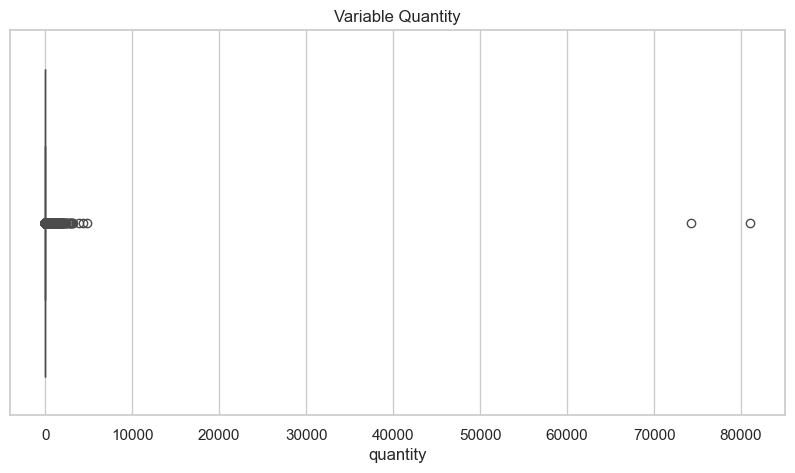

In [1642]:
# Graficar un boxplot para identificar valores atípicos
plt.figure(figsize=(10,5))
sns.boxplot(x=df['quantity'])
plt.title('Variable Quantity')
plt.show()

In [1643]:
#verificacion de los outliers, estos dos productos si son ventan por lo que no se eliminan 
df[df['quantity'] > 60000]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total,month_year,numero_compras,ingresos_totales,estado_cliente,AVP,APF,CLTV
36985,541431,23166,medium ceramic top storage jar,74215,2020-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,2020-01,1,77183.6,perdido,77183.6,0.000231,1057.309589
396017,581483,23843,paper craft little birdie,80995,2020-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,2020-12,3,168472.5,retenido,56157.5,0.000692,2307.842466


In [1644]:

# Aplicacion del metodo RFM 

current_date = df['invoice_date'].max()

# Calcula Recencia, Frecuencia y Valor Monetario
rfm_df = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (current_date - x.max()).days,
    'total': ['sum', 'count'],

})

rfm_df.columns = ['Recency', 'Monetary', 'Frequency']
rfm_df.reset_index(inplace=True)

# Asigna puntuaciones RFM
rfm_df['R_rank'] = pd.qcut(rfm_df['Recency'], 5, labels=False, duplicates='drop') + 1
rfm_df['F_rank'] = pd.qcut(rfm_df['Frequency'], 5, labels=False, duplicates='drop') + 1
rfm_df['M_rank'] = pd.qcut(rfm_df['Monetary'], 5, labels=False, duplicates='drop') + 1



# Puedes combinar las puntuaciones en un código RFM para cada cliente
rfm_df['RFM_Score'] = rfm_df['R_rank'] + rfm_df['F_rank'] + rfm_df['M_rank']


display(rfm_df.head())

,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score
0,12346,326,77183.60,1,5,1,5,11
1,12347,1,4310.00,182,1,5,5,11
2,12348,74,1437.24,27,4,2,4,10
3,12349,18,1457.55,72,2,4,4,10
4,12350,310,294.40,16,5,2,2,9


# NUEVO DF 

In [1645]:
# Aplicar IQR para Recency, Frequency, y Monetary
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

rfm_df = remove_outliers(rfm_df, 'Recency')
rfm_df = remove_outliers(rfm_df, 'Frequency')
rfm_df = remove_outliers(rfm_df, 'Monetary')

In [1646]:
rfm_df = rfm_df.merge(df[['customer_id', 'CLTV', 'estado_cliente']].drop_duplicates(), on='customer_id', how='left')

In [1647]:
rfm_df

,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score,CLTV,estado_cliente
0,12348,74,1437.24,27,4,2,4,10,19.688219,retenido
1,12349,18,1457.55,72,2,4,4,10,19.966438,retenido
2,12350,310,294.40,16,5,2,2,9,4.032877,retenido
3,12352,35,1385.74,77,3,4,4,11,18.982740,retenido
4,12353,203,89.00,4,5,1,1,7,1.219178,retenido
...,...,...,...,...,...,...,...,...,...,...
3497,18278,73,173.90,9,4,1,1,6,2.382192,retenido
3498,18280,277,180.60,10,5,1,1,7,2.473973,retenido
3499,18281,180,80.82,7,5,1,1,7,1.107123,retenido
3500,18282,7,178.05,12,1,1,1,3,2.439041,retenido


In [1648]:
def asignar_segmento(Recency, Frequency, Monetary, cltv):
    if cltv > rfm_df['CLTV'].quantile(0.75):
        return 'Alto Valor'
    elif Frequency >= rfm_df['Frequency'].quantile(0.75):
        return 'Leal'
    elif Recency <= rfm_df['Recency'].quantile(0.25) and cltv >= rfm_df['CLTV'].quantile(0.50):
        return 'Potencial'
    elif Frequency >= rfm_df['Frequency'].quantile(0.50) and Recency <= rfm_df['Recency'].quantile(0.50):
        return 'Activo'
    elif cltv < rfm_df['CLTV'].quantile(0.25):
        return 'Cliente alto riesgo'
    else:
        return 'Valor Medio'


# Aplicar la función asignar_segmento a cada fila de rfm_df
rfm_df['CLTV_Segment'] = rfm_df.apply(lambda x: asignar_segmento(x['Recency'], x['Frequency'], x['Monetary'], x['CLTV']), axis=1)


In [1649]:
def asignar_segmento(Recency, Frequency, Monetary, cltv):
    if cltv > rfm_df['CLTV'].quantile(0.8):  # Segmento más alto
        return 'Alto Valor'
    elif cltv > rfm_df['CLTV'].quantile(0.6):  # Segmento alto-medio
        return 'Leal'
    elif cltv > rfm_df['CLTV'].quantile(0.4):  # Segmento medio
        return 'Potencial'
    elif cltv > rfm_df['CLTV'].quantile(0.2):  # Segmento bajo-medio
        return 'Activo'
    else:  # Segmento más bajo
        return 'En riesgo/ Perdido'

# Aplicar la función al DataFrame
rfm_df['CLTV_Segment'] = rfm_df.apply(lambda x: asignar_segmento(x['Recency'], x['Frequency'], x['Monetary'], x['CLTV']), axis=1)



In [1650]:
rfm_df.sample(50)

,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score,CLTV,estado_cliente,CLTV_Segment
1524,14954,11,336.17,85,1,4,2,7,4.605068,retenido,Activo
2158,16017,46,211.88,32,3,3,1,7,2.902466,retenido,En riesgo/ Perdido
2639,16828,111,113.50,7,4,1,1,6,1.554795,retenido,En riesgo/ Perdido
1917,15603,78,48.48,2,4,1,1,6,0.664110,retenido,En riesgo/ Perdido
3136,17670,227,205.70,11,5,1,1,7,2.817808,retenido,En riesgo/ Perdido
2434,16463,20,1422.40,82,2,4,4,10,19.484932,retenido,Alto Valor
1362,14665,60,1835.70,90,3,4,4,11,25.146575,retenido,Alto Valor
1225,14441,0,1712.89,51,1,3,4,8,23.464247,retenido,Alto Valor
2117,15938,111,404.58,18,4,2,2,8,5.542192,retenido,Activo
2150,16005,11,615.39,218,1,5,3,9,8.430000,retenido,Potencial


In [1651]:
#Funcion para la segmentacion de los clientes segun su RFM score
def segment_customer(row):
   if row['RFM_Score'] > 12:
         return 'Alto valor'
   elif row['RFM_Score'] > 9:
    return 'Leal'
   elif row['RFM_Score'] > 6:
    return 'Potencial'
   elif row['RFM_Score'] > 3:
    return 'Activo'
   else:
     return 'Cliente Perdido' 

#Aplica la función de segmentación a cada fila del DataFrame
rfm_df['Segment'] = rfm_df.apply(segment_customer, axis=1)

#display(rfm_df.head())

In [1652]:
# Conteo de clientes por segmento
print(rfm_df['Segment'].value_counts())

Segment
Potencial          1665
Leal               1114
Activo              590
Alto valor           98
Cliente Perdido      35
Name: count, dtype: int64


In [1653]:
rfm_df.sample(20)

,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score,CLTV,estado_cliente,CLTV_Segment,Segment
3360,18059,22,306.46,18,2,2,2,6,4.198082,retenido,Activo,Activo
85,12493,165,415.74,21,4,2,2,8,5.695068,retenido,Potencial,Potencial
2251,16164,16,822.48,34,2,3,3,8,11.266849,retenido,Leal,Potencial
2925,17314,24,2527.92,131,2,5,5,12,34.629041,retenido,Alto Valor,Leal
636,13455,24,1058.34,46,2,3,4,9,14.497808,retenido,Leal,Potencial
2615,16788,122,595.83,154,4,5,3,12,8.162055,retenido,Potencial,Leal
2085,15872,14,360.93,128,2,5,2,9,4.944247,retenido,Activo,Potencial
1002,14046,284,151.59,13,5,1,1,7,2.076575,retenido,En riesgo/ Perdido,Potencial
3185,17754,0,1772.26,92,1,4,4,9,24.277534,retenido,Alto Valor,Potencial
576,13345,288,389.50,20,5,2,2,9,5.335616,retenido,Activo,Potencial


In [1654]:
rfm_df['CLTV_Segment'].value_counts()


CLTV_Segment
Alto Valor            701
En riesgo/ Perdido    701
Activo                700
Leal                  700
Potencial             700
Name: count, dtype: int64

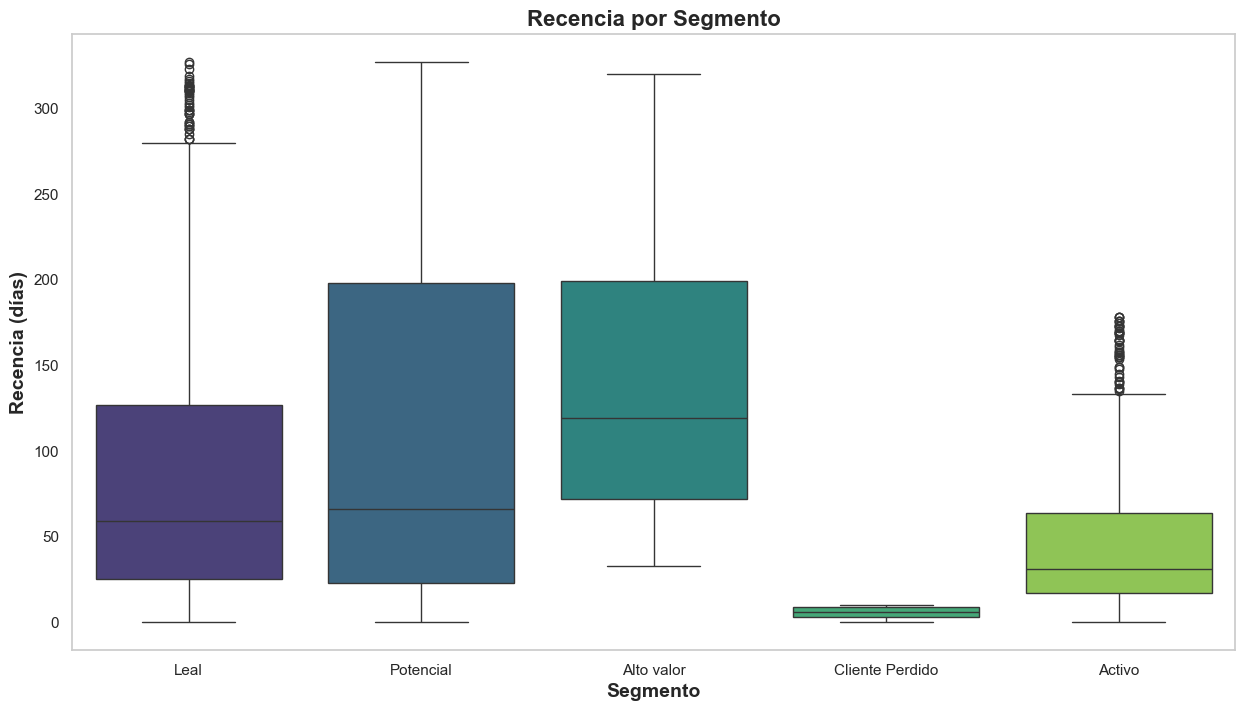

In [1655]:
# Gráfico de Caja y Bigote para Recencia por Segmento
plt.figure(figsize=(15, 8))
sns.boxplot(data=rfm_df, x='Segment', y='Recency', palette='viridis', hue='Segment')
plt.title('Recencia por Segmento', fontsize=16, fontweight='bold')
plt.xlabel('Segmento', fontsize=14, fontweight='bold')
plt.ylabel('Recencia (días)', fontsize=14, fontweight='bold')
#plt.xticks(rotation=45)
plt.grid(False)
plt.savefig('recencia_por_segmento.jpeg', format='jpeg')
plt.show()



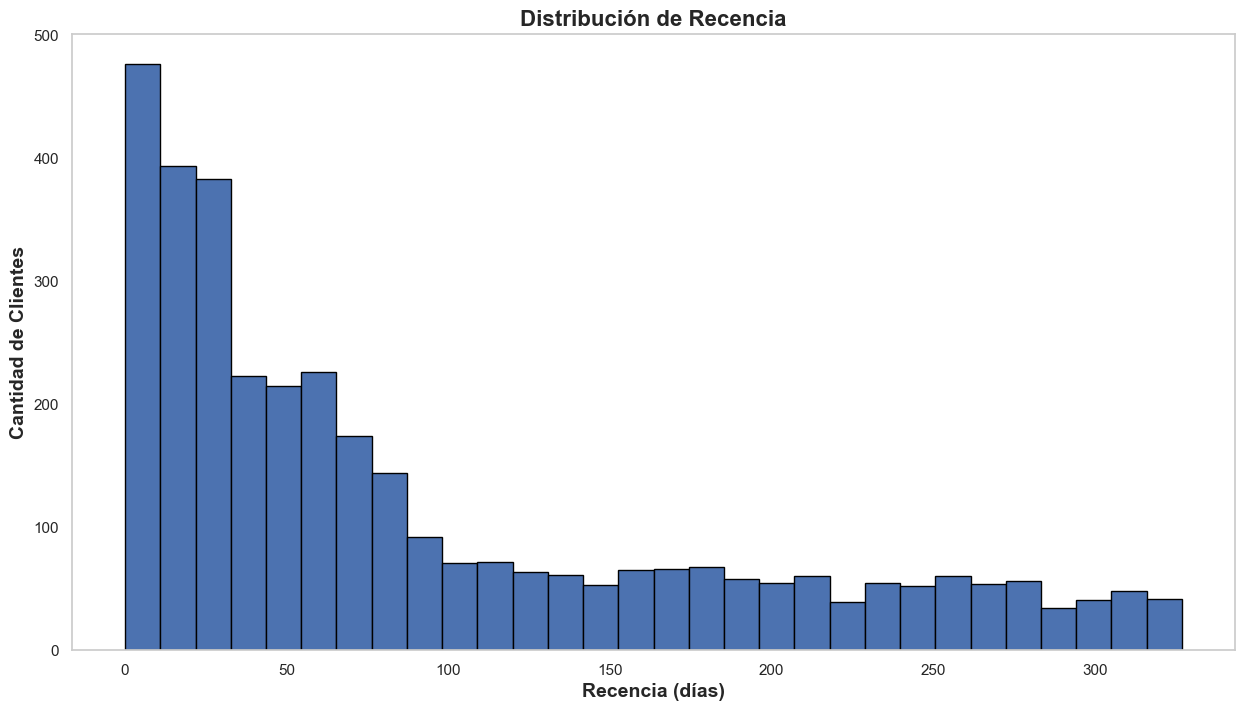

In [1656]:
# Histograma
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))
rfm_df['Recency'].hist(bins=30, edgecolor='black', grid=False)
plt.title('Distribución de Recencia', fontsize=16, fontweight='bold')
plt.xlabel('Recencia (días)', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de Clientes', fontsize=14, fontweight='bold')
plt.savefig('distrubicion_de_recencia.jpeg', format='jpeg')
plt.show()



Se realizo un analisis para visualizar cuandos dias suelen esperar los clientes hasta su sigiente compra. Como se observa la mayoria de los clientes suelen esperar ente 50 y 70 dias entre sus compras.

Lo que observamos en esta gráfica es la distribución de clientes por su antigüedad. La mayor concentración de clientes se encuentra en el rango de 0 a 6 meses, lo que sugiere que la empresa tiene una alta tasa de adquisición de nuevos clientes. A medida que aumenta la antigüedad, el número de clientes disminuye, lo que indica que la empresa tiene cierta rotación de clientes.

Se muestra una distribución típica de clientes por antigüedad, con una alta concentración de nuevos clientes y una disminución gradual a medida que aumenta la antigüedad. Esto sugiere que la empresa es efectiva en la adquisición de nuevos clientes, pero necesita mejorar sus estrategias de retención para mantener a los clientes a lo largo del tiempo.


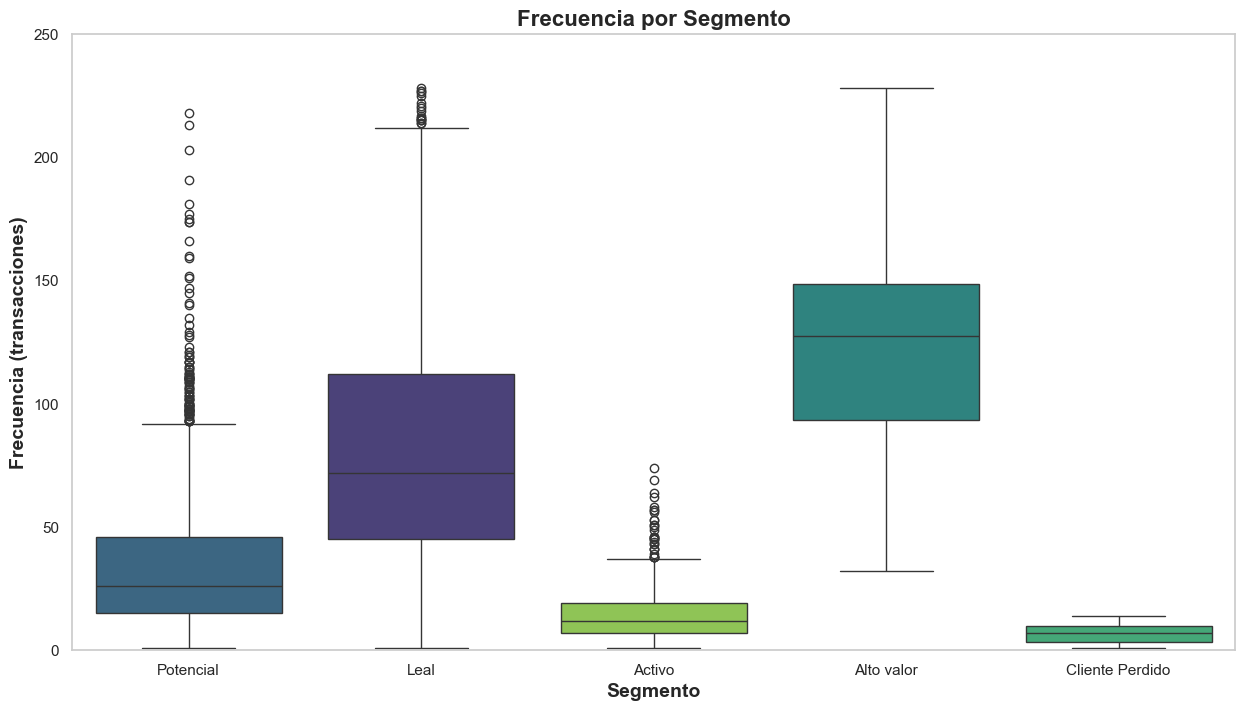

In [1657]:
# Gráfico de Caja y Bigote para Frecuencia por Segmento
plt.figure(figsize=(15, 8))
sns.boxplot(data=rfm_df, x='Segment', y='Frequency', palette='viridis', order=rfm_df['Segment'].value_counts().index, hue='Segment' )#showfliers=False
plt.title('Frecuencia por Segmento',  fontsize=16, fontweight='bold')
plt.xlabel('Segmento',  fontsize=14, fontweight='bold')
plt.ylabel('Frecuencia (transacciones)',  fontsize=14, fontweight='bold')
#plt.xticks(rotation=45)
#plt.ylim(0, 410) CON OUTLIERS
plt.ylim(0, 250)
plt.grid(False)
plt.savefig('frecuencia_por_segmento.jpeg', format='jpeg')
plt.show()



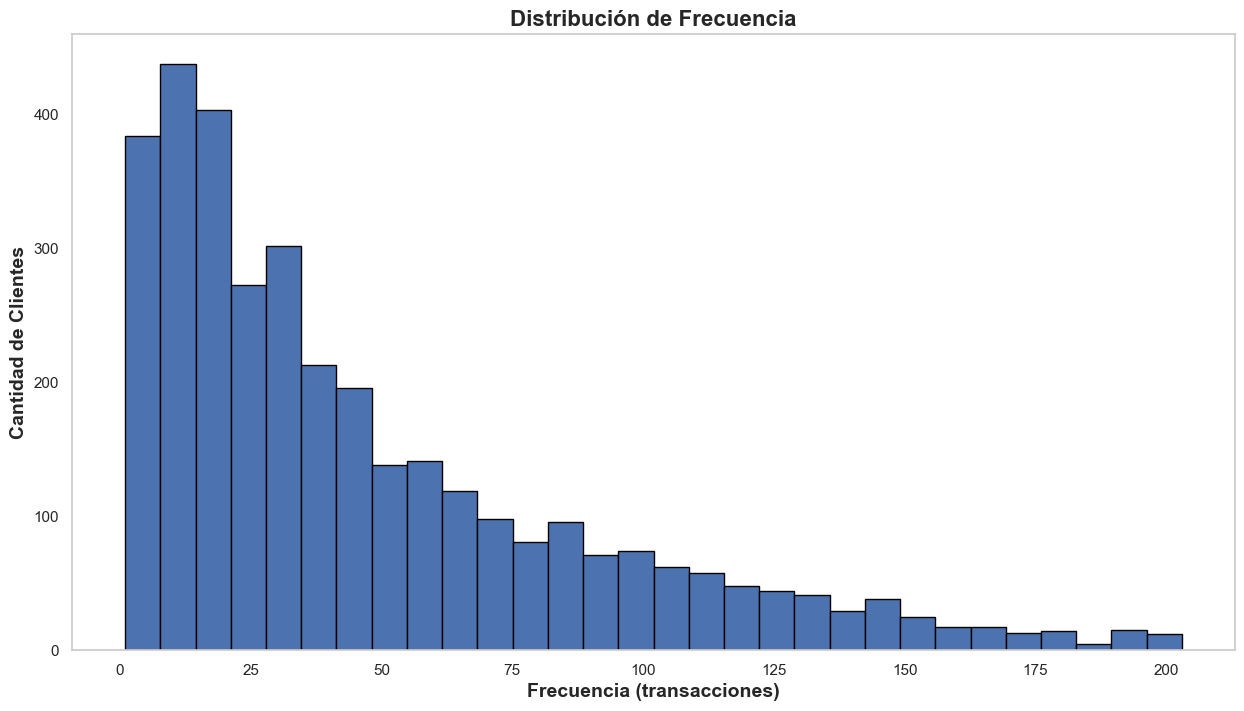

In [1658]:
#histograma
sns.set(style="whitegrid")
filtered_data_f = rfm_df[rfm_df['Frequency'] < rfm_df['Frequency'].quantile(0.99)]
plt.figure(figsize=(15, 8))
filtered_data_f['Frequency'].hist(bins=30, edgecolor='black', grid=False)
plt.title('Distribución de Frecuencia', fontsize=16, fontweight='bold')
plt.xlabel('Frecuencia (transacciones)', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de Clientes', fontsize=14, fontweight='bold')
plt.savefig('distribucion_de_frecuencia.jpeg', format='jpeg')
plt.show()



Podemos observar que existe mas cantidad de cuentes que realizan entre 1 y 50 compras, mientras que resulta menos comun que los clientes realicen mas de 100 compras dentro de la tienda. La alta concentración de clientes en el rango de 1 a 50 compras sugiere que la empresa tiene una base de clientes amplia y diversa, con muchos clientes que realizan compras ocasionales o de baja frecuencia.

La presencia de clientes que realizan más de 100 compras indica que la empresa tiene un segmento de clientes leales y comprometidos que generan un alto volumen de ventas. Sin embargo, el número relativamente bajo de clientes en este segmento sugiere que existe un potencial para aumentar la fidelidad y el gasto entre los clientes existentes.

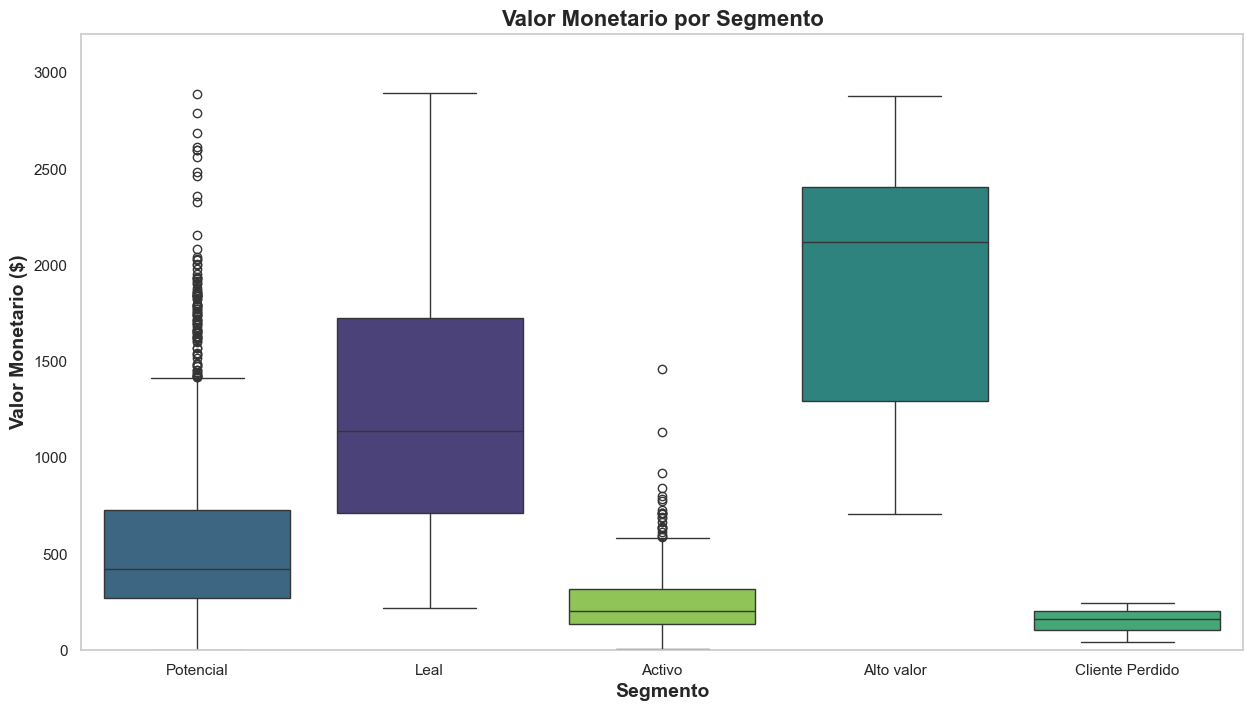

In [1659]:
# Gráfico de Caja y Bigote para Valor Monetario por Segmento
plt.figure(figsize=(15, 8))
sns.boxplot(data=rfm_df, x='Segment', y='Monetary', palette='viridis', order=rfm_df['Segment'].value_counts().index, hue='Segment')
plt.title('Valor Monetario por Segmento', fontsize=16, fontweight='bold')
plt.xlabel('Segmento', fontsize=14, fontweight='bold')
plt.ylabel('Valor Monetario ($)', fontsize=14, fontweight='bold')
#plt.xticks(rotation=45)
#plt.ylim(0, 7000) CON OUTLIERS
plt.ylim(0, 3200)
plt.grid(False)
plt.savefig('valor_monetario_por_segmento.jpeg', format='jpeg')
plt.show()


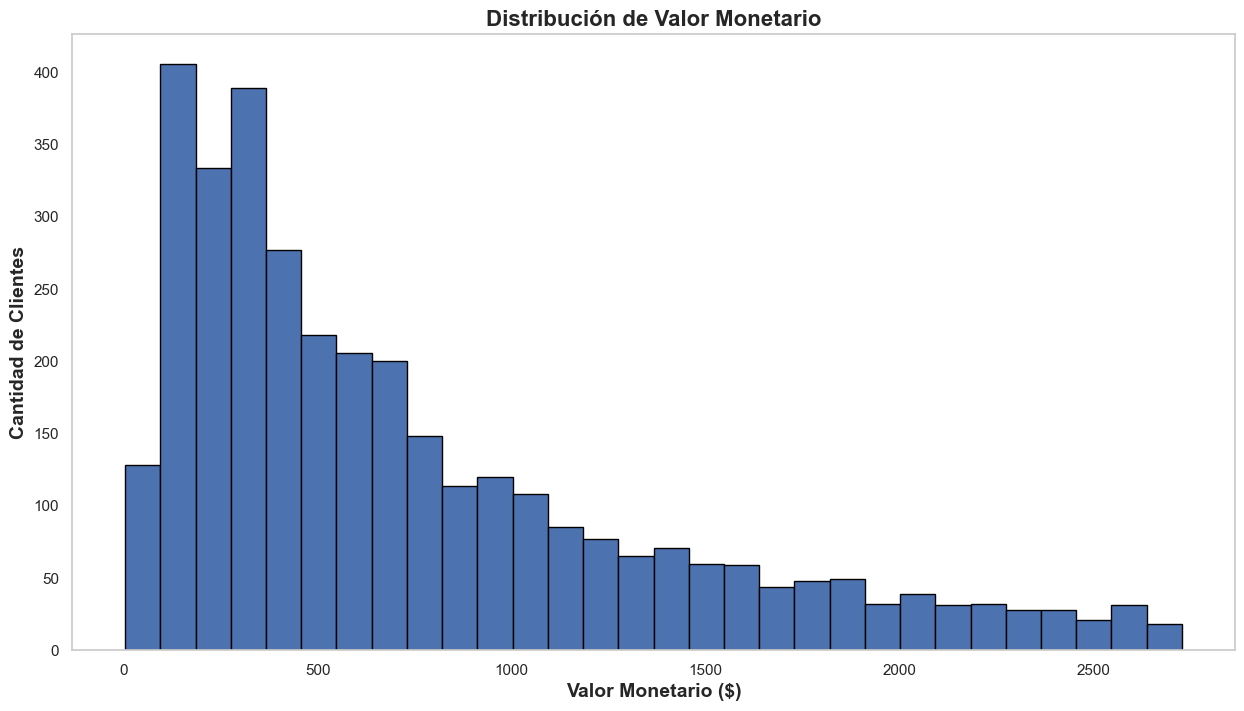

In [1660]:
#histograma
sns.set(style="whitegrid")
filtered_data_m = rfm_df[rfm_df['Monetary'] < rfm_df['Monetary'].quantile(0.99)]
plt.figure(figsize=(15, 8))
filtered_data_m['Monetary'].hist(bins=30, edgecolor='black', grid= False)
plt.title('Distribución de Valor Monetario', fontsize=16, fontweight='bold')
plt.xlabel('Valor Monetario ($)', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de Clientes', fontsize=14, fontweight='bold')
plt.ticklabel_format(style='plain', axis='x')
plt.savefig('distribucion_valor_monetario.jpeg', format='jpeg')
plt.show()



Se observa que la mayoría de los clientes se encuentran en el rango de $0 a $200, mientras que es menos común que los clientes gasten más de $1000.
La alta concentración de clientes en el rango de $0 a $200 sugiere que la empresa tiene una base de clientes amplia y diversa, con muchos clientes que realizan compras de bajo valor.

La presencia de clientes que gastan más de $1000 indica que la empresa tiene segmentos de clientes con mayor poder adquisitivo que realizan compras de alto valor. Sin embargo, el número relativamente bajo de clientes en este segmento sugiere que existe un potencial para aumentar las ventas entre estos clientes.


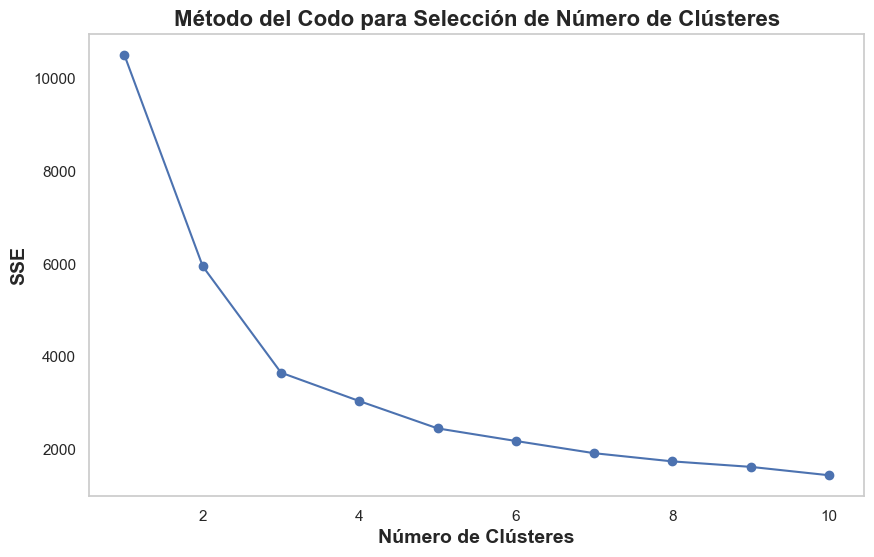

In [1661]:
# Normalizar los datos
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Método del codo para encontrar el número óptimo de clústeres
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Método del Codo para Selección de Número de Clústeres', fontsize=16, fontweight='bold')
plt.xlabel('Número de Clústeres', fontsize=14, fontweight='bold')
plt.ylabel('SSE', fontsize=14, fontweight='bold')
plt.grid(False)
plt.show()
# Aplicar k-means con el número óptimo de clústeres (supongamos k=5)


In [1662]:
# Aplicar k-means con el número óptimo de clústeres 
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_normalized)


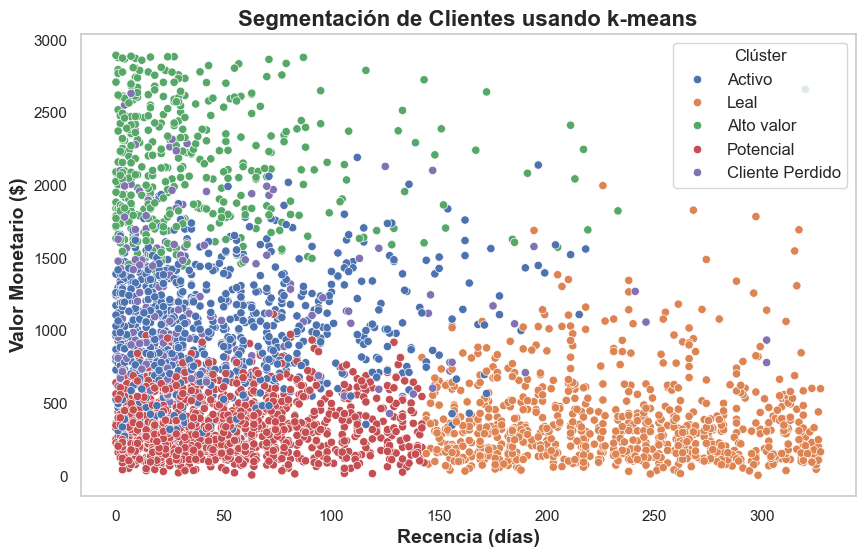

In [1663]:
# Crear un diccionario de mapeo de etiquetas
cluster_names = {
    0: 'Potencial',
    1: 'Cliente Perdido',
    2: 'Leal',
    3: 'Alto valor',
    4: 'Activo'
}

# Asignar las etiquetas a cada cliente
rfm_df['Cluster_name'] = rfm_df['Cluster'].map(cluster_names)

# Visualizar los clústeres
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster_name')
plt.title('Segmentación de Clientes usando k-means', fontsize=16, fontweight='bold')
plt.xlabel('Recencia (días)', fontsize=14, fontweight='bold')
plt.ylabel('Valor Monetario ($)', fontsize=14, fontweight='bold')
plt.legend(title='Clúster', fontsize=12)
plt.grid(False)
plt.ticklabel_format(style='plain', axis='y')
plt.savefig('segmentacion de clientes k-means.jpeg', format='jpeg')
plt.show()

In [1664]:
# Distribución de clientes por clúster
rfm_df['Cluster'].value_counts()

Cluster
0    1230
2     828
4     825
3     411
1     208
Name: count, dtype: int64

In [1665]:
print(rfm_df['Cluster_name'].value_counts())

Cluster_name
Potencial          1230
Leal                828
Activo              825
Alto valor          411
Cliente Perdido     208
Name: count, dtype: int64


In [1666]:
# Distribución de clientes por clúster ordenado
print(rfm_df['Cluster_name'].value_counts())

# Estadísticas descriptivas por clúster ordenado
cluster_summary_ordered = rfm_df.groupby('Cluster_name').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'count']
}).round(1)
display("Cluster Summary Ordered:", cluster_summary_ordered)

Cluster_name
Potencial          1230
Leal                828
Activo              825
Alto valor          411
Cliente Perdido     208
Name: count, dtype: int64


'Cluster Summary Ordered:'

Recency        Frequency        Monetary              
                   mean median      mean median     mean  median count
Cluster_name                                                          
Activo             48.9   35.0      59.5   58.0   1017.8   994.6   825
Alto valor         39.3   24.0     105.1  104.0   2137.0  2102.1   411
Cliente Perdido    42.8   24.0     163.9  157.5   1123.1   984.3   208
Leal              232.8  234.0      22.3   17.0    368.9   305.5   828
Potencial          52.6   46.0      22.2   20.0    355.4   328.3  1230

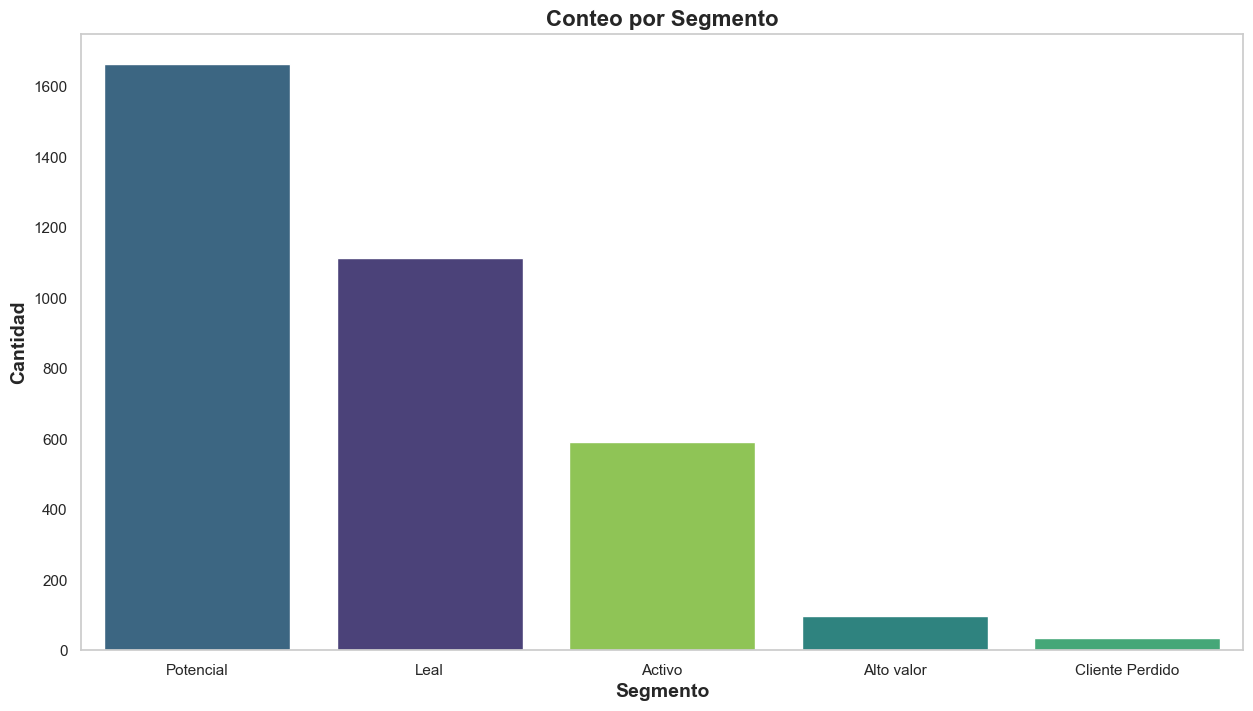

In [1667]:
# Gráfico de Barras de la Distribución de Segmentos

sns.set(style="whitegrid")

plt.figure(figsize=(15,8))
sns.countplot(data=rfm_df, x='Segment', order=rfm_df['Segment'].value_counts().index, hue='Segment', palette='viridis', legend=False)


plt.title('Conteo por Segmento', fontsize=16, fontweight='bold')
plt.xlabel('Segmento', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad', fontsize=14, fontweight='bold')

plt.grid(False)
plt.savefig('conteo_por_segmento.jpeg', format='jpeg')
plt.show()

Se realizo una segmentacion de cliente con base en la frecuencia con la que compran en la tienda, el monto que suelen gastar en sus compras y el tiempo transcurrido desde su ultima combra. Se obtuvieron 5 segmentos que dividen a los clientes en:
- *Potencial*: Son clientes con actividad superior a la media, en los cuales podemos enformar algun programa especifico para incentivarlos a convertirlos en clientes leales o de alto valor.
- *Leal*: En este grupo encontraremos a los clientes aliosos para la empresa, ya que son propensos a realizar compras repetidas y recomendar nuestros productos o servicios a otros.
- *Activo*: Clientes que utilizan compran nuestros productos de manera regular, sin llegar a superar el promedio de compras o visitas. Este segmento representa la mayor oportunidad de crecimiento para la empresa. Se deben implementar estrategias para aumentar la satisfacción y la lealtad de estos clientes.
- *Alto valor*: Estos clientes generan la mayor parte de los ingresos para la empresa. Es importante enfocarse en este segmento para mantener su satisfacción y lealtad.
- *Cliente Churn*: Estos clientes ya no compran nuestros productos. Es de vital importancia enfocarse en este segmento y analizar las razones por las que estos clientes se han perdido y tomar medidas para evitar que otros clientes se pierdan en el futuro.

In [1668]:
#Creacion de la columna de cancelacion
def churn(row):
    if row == 'perdido':
        return 1 # cliente perdido o que probablemente abandone pronto
    else:
        return 0 #menos probabilidad de abandono 



rfm_df['Churn'] = rfm_df['estado_cliente'].apply(churn)

# Modelo

In [1669]:
# Invertir Recency para que los valores más altos sean mejor (menor recencia es mejor)
rfm_df['Recency'] = -rfm_df['Recency']

# Características adicionales
df_additional = df.groupby('customer_id').agg({
    'invoice_date': [lambda x: (current_date - x.min()).days,  # Customer Lifetime
                        lambda x: x.diff().mean().days],          # Average Time Between Purchases
    'stock_code': pd.Series.nunique,                                # Number of Distinct Products
   
})

df_additional.columns = ['Customer_Lifetime', 'Avg_Time_Between_Purchases', 'Distinct_Products']
df_additional.reset_index(inplace=True)

# Unir las características adicionales con las métricas RFM
rfm_df = pd.merge(rfm_df, df_additional, on='customer_id')
rfm_df.sample(20)

,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score,CLTV,estado_cliente,CLTV_Segment,Segment,Cluster,Cluster_name,Churn,Customer_Lifetime,Avg_Time_Between_Purchases,Distinct_Products
72,12463,-52,1200.78,79,3,4,4,11,16.449041,retenido,Leal,Leal,4,Activo,0,241,2.0,64
1341,14633,-265,344.90,20,5,2,2,9,4.724658,retenido,Activo,Potencial,2,Leal,0,265,0.0,20
148,12592,-91,401.60,16,4,2,2,8,5.501370,retenido,Activo,Potencial,0,Potencial,0,212,8.0,10
3137,17671,-15,1572.71,53,2,3,4,9,21.543973,retenido,Alto Valor,Potencial,4,Activo,0,365,6.0,40
1028,14098,-36,147.35,21,3,2,1,6,2.018493,retenido,En riesgo/ Perdido,Activo,0,Potencial,0,36,0.0,21
2665,16875,-66,2095.53,112,3,4,5,12,28.705890,retenido,Alto Valor,Leal,3,Alto valor,0,340,2.0,93
1703,15240,-44,1706.57,78,3,4,4,11,23.377671,retenido,Alto Valor,Leal,3,Alto valor,0,312,3.0,58
657,13487,-57,575.40,34,3,3,3,9,7.882192,retenido,Potencial,Potencial,0,Potencial,0,353,8.0,26
1456,14836,-9,102.45,6,1,1,1,3,1.403425,retenido,En riesgo/ Perdido,Cliente Perdido,0,Potencial,0,29,4.0,5
209,12693,-126,711.91,35,4,3,3,10,9.752192,retenido,Leal,Leal,0,Potencial,0,319,5.0,34


Churn
0    3444
1      58
Name: count, dtype: int64


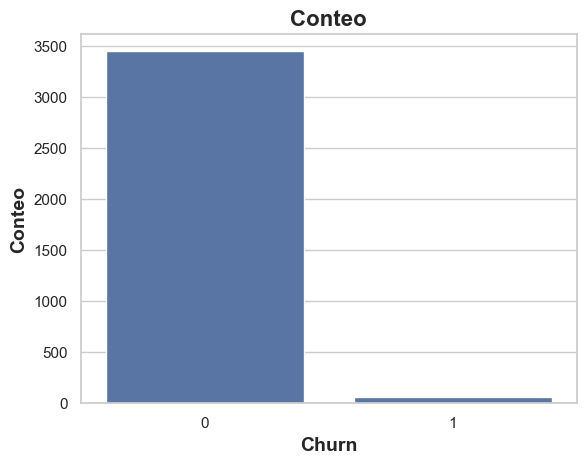

In [1670]:
#Vamos a explorar como se comporta nuestra variable objetivo
class_counts = rfm_df['Churn'].value_counts()

print(class_counts)

plt.title('Conteo', fontsize=16, fontweight='bold')
plt.xlabel('Churn', fontsize=14, fontweight='bold')
plt.ylabel('Conteo', fontsize=14, fontweight='bold')
sns.countplot(x='Churn', data=rfm_df)
plt.show()

Se observa que nuestros datos se encuentran totalmente desbalanceados, dato a tomar en cuenta para la prediccion.

In [1671]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = rfm_df[['Recency', 'Frequency', 'Monetary', 'Distinct_Products']]
y = rfm_df['Churn']

# Ajustar y transformar el conjunto de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12345)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=12345)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [1672]:
# Crear un pipeline para el manejo de los modelos

pipelines = {
        'xgb': Pipeline([
        ('scaler', StandardScaler()),  # Escalador estándar
        ('classifier', XGBClassifier(random_state=42))
    ]),
    'lgr': Pipeline([
        ('scaler', StandardScaler()),  # Escalador estándar
        ('classifier', LogisticRegression(penalty="elasticnet", l1_ratio=0.5))  
    ]),
    'knn': Pipeline([
        ('scaler', StandardScaler()),  # Escalador estándar
        ('classifier', KNeighborsClassifier())
    ])
}

In [1673]:
param_grids = {
    
    'xgb': {'classifier__n_estimators': [10, 30, 50],
           'classifier__subsample': [0.8, 0.9, 1],
           'classifier__gamma': [0, 0.1, 0.200],
           'classifier__learning_rate': [0.1, 0.01, 0.001],
           'classifier__colsample_bytree': [0.8, 0.9, 1],
           'classifier__max_depth': [3, 5, 10]},
           
    'lgr': {
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__class_weight': ['balanced']
    },
    'knn': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto'],
        'classifier__leaf_size': [10, 30, 50],
        'classifier__p': [1, 2]
    }
}


In [1674]:
# Inicializar una lista para almacenar los resultados
results = []

stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=stratified_k_fold,
                               scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Evaluar el modelo en el conjunto de prueba
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
    y_pred = grid_search.predict(X_test)
    
        # Aplicar umbral a las probabilidades
    umbral = 0.5  # Umbral de 0.5 para clasificación binaria
    y_pred_binario = np.where(y_pred_proba >= umbral, 1, 0)

    # Calcular la precisión con las predicciones binarias
    acc_score = accuracy_score(y_test, y_pred_binario)
    f1 = f1_score(y_test, y_pred_binario)
    precision = precision_score(y_test, y_pred_binario)
    recall = recall_score(y_test, y_pred_binario)
    roc_auc = roc_auc_score(y_test, y_pred_binario)
    
    # Guardar los resultados en la lista
    results.append({
        'Modelo': model_name,
        'AUC-ROC': roc_auc,
        'Exactitud': acc_score,
        'f1': f1,
        'Precision': precision,
        'recall': recall,
        'Mejores Parámetros': grid_search.best_params_,
        'Mejor AUC-ROC': grid_search.best_score_
    })

# Crear el DataFrame de resultados
results_df = pd.DataFrame(results)

# Mostrar la tabla de resultados
print(results_df)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\karin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Modelo   AUC-ROC  Exactitud   f1  Precision    recall  \
0    xgb  1.000000   1.000000  1.0   1.000000  1.000000   
1    lgr  0.959302   0.920000  0.3   0.176471  1.000000   
2    knn  0.666667   0.988571  0.5   1.000000  0.333333   

                                  Mejores Parámetros  Mejor AUC-ROC  
0  {'classifier__colsample_bytree': 0.8, 'classif...       1.000000  
1  {'classifier__class_weight': 'balanced', 'clas...       0.995494  
2  {'classifier__algorithm': 'auto', 'classifier_...       0.966889  


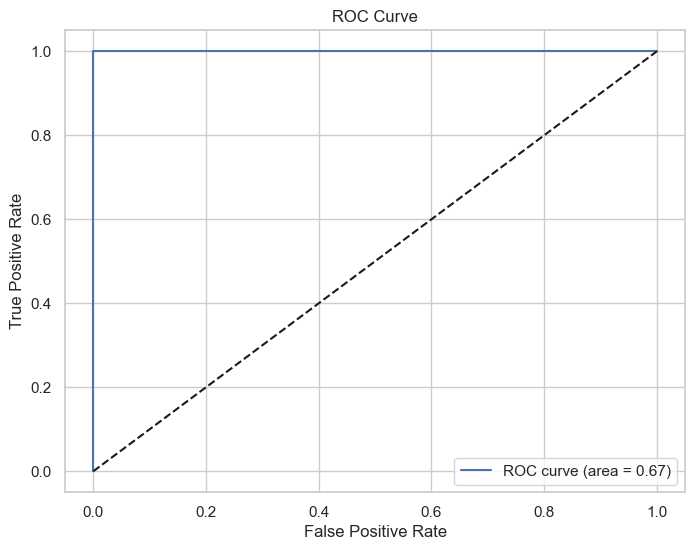

In [1675]:
best_model = pipelines[results_df.sort_values('AUC-ROC', ascending=False).iloc[0]['Modelo']]
best_model.fit(X_train, y_train)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Recomendaciones:

Con base en el analisis y la segmentacion de los datos realizados:

- **Implementar programas de fidelización para clientes**: Los programas de fidelización pueden ayudar a mantener a los clientes comprometidos y reducir la rotación. Estos programas pueden ofrecer beneficios como descuentos, puntos, acceso anticipado a nuevos productos o servicios, y eventos exclusivos.

- **Mejorar el servicio al cliente**: Un buen servicio al cliente puede ayudar a aumentar la satisfacción del cliente y reducir la probabilidad de que se vayan. La empresa debe asegurarse de que sus canales de servicio al cliente sean accesibles y fáciles de usar, y que sus empleados estén capacitados para brindar un servicio de alta calidad.

- **Analizar las razones por las que los clientes se van**: Es importante comprender por qué los clientes se van para poder abordar las causas subyacentes. La empresa puede realizar encuestas de salida o entrevistas a los clientes perdidos para obtener información sobre sus razones para irse.

- **Analizar los factores que impulsan la fidelización**: La empresa debería investigar los factores que impulsan la fidelización de los clientes que realizan más de 100 compras. Esto podría ayudar a identificar estrategias para aumentar la fidelidad entre otros segmentos de clientes.

- **Personalizar las comunicaciones de marketing**: La empresa podría personalizar sus comunicaciones de marketing en función del historial de compras de cada cliente. Esto podría ayudar a aumentar la relevancia de los mensajes de marketing y fomentar la conversión.

- **Analizar los factores que influyen en el gasto**: La empresa debería investigar los factores que influyen en el gasto de los clientes en diferentes rangos de precios. Esto podría incluir factores demográficos, psicográficos, comportamentales y relacionados con los productos y servicios de la empresa.

- **Implementar estrategias para aumentar el gasto promedio**: La empresa podría implementar estrategias para aumentar el gasto promedio de los clientes en el rango de $0 a $200. Esto podría incluir ofrecer descuentos por volumen, promociones especiales, programas de fidelización o mejorar la experiencia de compra en la tienda.

- **Atraer y fidelizar a los clientes de alto valor**: La empresa podría implementar estrategias de marketing personalizadas para atraer y fidelizar a los clientes que gastan más de $1000. Esto podría incluir ofrecer productos y servicios exclusivos, brindar un servicio al cliente excepcional o invitar a eventos especiales.